In [33]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as ml
import scipy as sp
import scipy.signal as sig
import fnmatch
import os


def get_file_data(filename):
    try: 
        err = "Error: 0-D Array, skipping "
        file = np.loadtxt(filename)
        if file.ndim == 0:
            return str(err)+str(file)
        count = 0
        for i in file:
            if i == 1111111111:
                break
            else:
                count += 1
                continue

        time = np.zeros(count)
        wave = np.zeros(count)

        for i in range(count):
            time[i] = file[i]
            wave[i] = file[count+1+i]
            
    except FileNotFoundError:
        #Error Handling: If a filenotfound error occurs during the data processing
        time = np.linspace(0,50,500000)
        wave = np.ones(500000)
        print("FILE NOT FOUND:")
        print("Plots petaining to: "+str(filename)+" should be ignored")
        filename = "FILE NOT FOUND: PLEASE IGNORE"
        
    return time, wave, filename




def plotter(filename):
    #input file name as string (ex: "file")
    
    my_path = '/global/u2/z/zendejas/CUORE/Raw_Data/root_files/Data_Output/Timestreams/'
    time, wave, filename = get_file_data(filename)

    plt.figure()
    plt.plot(time, wave)
    plt.xlabel("Time [Seconds]")
    plt.ylabel("Amplitude [mV ?]")
    plt.title("Timestream of File: "+str(filename))
    
    my_file = "Timestream of File: "+str(filename)
    #plt.savefig(os.path.join(my_path, my_file))
    
    plt.show()


    
    
    
def power_spectral_density(filename, sampling_rate):
    #input file name as string (ex: "file")
    foldername = "PSDs"
    my_path = '/global/u2/z/zendejas/CUORE/Raw_Data/root_files/Data_Output/PSDs/'
    time, wave, filename = get_file_data(filename)

    f, pxx = sig.periodogram(wave, fs=sampling_rate)
    plt.figure()
    plt.loglog(f, pxx)
    plt.xlabel("Frequency [Hz]")
    plt.ylabel("Amplitude")
    plt.xlim(0.1,5000)
    plt.ylim(1E-16,1E-1)
    plt.title("PSD of File: "+str(filename))
    plt.grid()
    my_file = "PSD of File: "+str(filename)
    #plt.savefig(os.path.join(my_path, my_file))
    #plt.show()
    

    

    
def gauss_wind(N, sigma):
    M = N - 2 
    w = np.zeros(M+1)
    for i in range(M+1):
        w[i] = np.exp(-0.5*(((i - M)/2)/(sigma*M/2))*(((i - M)/2)/(sigma*M/2)))
    return w
        
def butter_lowpass(cutoff, fs, order=5):
    #fs sample rate in Hz
    #desired cutoff frequency of filter in Hz
    nyq = 0.5*fs
    normal_cutoff = cutoff / nyq
    b, a = sp.signal.butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    #fs sample rate in Hz
    #desired cutoff frequency of filter in Hz
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = sp.signal.lfilter(b, a, data)
    return y



def plot_fft(xf, yfG, M, N, filename, xlim, ylim, my_path):
    dummy_none = None
    plt.figure()
    #kv squaring FFT
    yfGsquare = [i**2 for i in yfG]
    plt.loglog(xf, yfGsquare, label = 'Average of '+str(M)+', '+str(N)+' point samples with a Gaussian Window' )
    plt.legend()
    plt.title('Average of '+str(M)+', '+str(N)+' point samples')
    plt.title("FFT of File: "+str(filename))
    
    if type(xlim) == type(dummy_none):
        xlim_index = np.where(yfG >= 0.001*max(yfG))[0][-1]
        try:
            plt.xlim(-1, xf[xlim_index+10])
        except IndexError:
            plt.xlim(1, xf[xlim_index])
    elif type(xlim) == int:
        plt.xlim(0,xlim)
    elif type(xlim) == float:
        plt.xlim(-1,xlim)
    
    if type(ylim) == type(dummy_none):
        ylim = max(yfG) + 0.1*max(yfG)
        plt.ylim(0, ylim)    
    elif type(ylim) == int:
        plt.ylim(0,ylim)
    elif type(ylim) == float:
        plt.ylim(0,ylim)
    

    my_file = "FFT of File: "+str(filename)+" ( M = "+str(M)+', N= '+str(N)+" )"
    #plt.savefig(os.path.join(my_path, my_file))
    plt.grid()
    plt.show()

def calulate_FFT(windows_to_average, window_size, sampling_rate, cutoff, sampsG, micG, sumsG):
    
    for j in range(windows_to_average):
        sampsG[j] = micG[j*window_size : ((j*window_size)+(window_size-1))]
        if type(cutoff) != type(None):
            sampsG[j] = butter_lowpass_filter(sampsG[j], cutoff, fs=sampling_rate, order=4)
        np.multiply(sampsG[j], gauss_wind(window_size, 0.5), out = sampsG[j], casting = 'unsafe')
        sampsG[j] = np.fft.fft(sampsG[j])


    for k in range(windows_to_average):
        sumsG += sampsG[k]

        
    FFT_output = sumsG/windows_to_average
    yfG = 2/window_size*np.abs(FFT_output[1:window_size//2])
    
    return yfG
    
    

def get_FFT(filename, sampling_rate, window_size=None, windows_to_average=None, cutoff=None, xlim=None, ylim=None ):
    
    my_path = '/global/u2/z/zendejas/CUORE/Raw_Data/root_files/Data_Output/FFTs/'
    time, wave, filename = get_file_data(filename)
    
    if type(window_size) == type(None):
        window_size = len(time)
    
    if type(windows_to_average) == type(None):
        windows_to_average = 1
    
    xf = np.linspace(0, 1.0/(2.0/sampling_rate), window_size//2-1)
    
    
    sumsG = 0 
    sampsG = {}
    micG = np.copy(wave)

    yfG = calulate_FFT(windows_to_average, window_size, sampling_rate, cutoff, sampsG, micG, sumsG)
    plot_fft(xf, yfG, windows_to_average, window_size, filename, xlim, ylim, my_path)

    
    
    

def narrow(filename, tick_2):
    for file_narrow in os.listdir('.'):
            if filename in file_narrow:
                if ".root" in file_narrow:
                    file_narrow = file_narrow[:-5]
                    for file2 in os.listdir('.'):
                        if file_narrow in file2:
                            if ".root" not in file2:
                                #print(file2)
                                #file_array[tick_2] = file2
                                tick_2 += 1
                                #plotter(file2)
    return tick_2






def narrow2(filename, tick_2, file_array):
    for file_narrow in os.listdir('.'):
            if filename in file_narrow:
                if ".root" in file_narrow:
                    file_narrow = file_narrow[:-5]
                    for file2 in os.listdir('.'):
                        if file_narrow in file2:
                            if ".root" not in file2:
                                #print(file2)
                                file_array[tick_2] = file2
                                tick_2 += 1
                                #plotter(file2)
    return tick_2






def create_file_array(filename):
    tick = 0
    if filename == True:
        for file in os.listdir('.'):
            if ".root" in file:
                file = file[:-5]
                for file2 in os.listdir('.'):
                    if file in file2:
                        #print(file2)
                        tick +=1
                        #plotter(file2)
                
                        
                        
    elif type(filename) ==str :
        tick = narrow(filename, tick)
        
            
                
        if tick == 0:
            print("Invalid File Name, Please Try Again")
    
    elif type(filename) == int:
        filename = str(filename)
        tick = narrow(filename, tick)
        
                
        if tick == 0:
            print("Invalid File Name, Please Try Again")
        
    else:
        print("Invalid Arguement Given, Please Enter a String, Interger, or Leave Blank for all Files")
        
    #print(tick)
    file_array = [None] * tick
    
    return file_array
    
  




def assign_files_to_array(filename, file_array):
    tick_2 = 0
    if filename == True:
        for file in os.listdir('.'):
            if ".root" in file:
                file = file[:-5]
                for file2 in os.listdir('.'):
                    if file in file2:
                        #print(file2)
                        file_array[tick_2] = file
                        tick_2 += 1
                        #plotter(file2)


    elif type(filename) ==str :
        tick_2 = narrow2(filename, tick_2, file_array)
        


    elif type(filename) == int:
        filename = str(filename)
        tick_2 = narrow2(filename, tick_2, file_array)
                                    
    return file_array


def sort_file_array(file_array):
    l = len(file_array)
    p_vals = np.zeros(l)
    organized = [0]*l
    
    for i in range(l):
        p_vals[i] = int(file_array[i][-3::])
    A = np.sort(p_vals)
    
    for i in range(int(max(p_vals))):
        try:
            origin_index = np.where(p_vals == A[i])[0][0]
            organized[i]  = file_array[origin_index]
        except IndexError:
            pass
    return organized


def get_files(filename=True, sort=False):
    file_array = create_file_array(filename)
    file_array = assign_files_to_array(filename, file_array)
    if sort == True:
        file_array = sort_file_array(file_array)
    return file_array


def stitch_file_data(filename):
    file_array = get_files(filename, sort=True)
    l = len(file_array)
    full_time = np.arange(0,l*50, 0.000001)
    full_wave = np.zeros(len(full_time))
    for i in range(len(file_array)):
        time, wave, filename  = get_file_data(file_array[i])
        print(str(i)+" / "+str(len(file_array)))
        try:
            full_wave[(i*500000):(((i+1)*500000))] = wave
        except ValueError:
            full_wave[(i*500000):(i*500000)+len(wave)]
            ending_file = file_array[i]
            break
    print("There was a break in data collection after file: "+str(ending_file), '\n')
    print("Continue File stiching after the aforemention file", '\n')
    new_filename = input("Enter new filename for Stiched Data: ")
    data = np.array([full_time, full_wave])
    data = data.T
    datafile_path = str(new_filename)+".txt"
    np.savetxt(datafile_path, data)
    return full_time, full_wave


<Figure size 432x288 with 0 Axes>

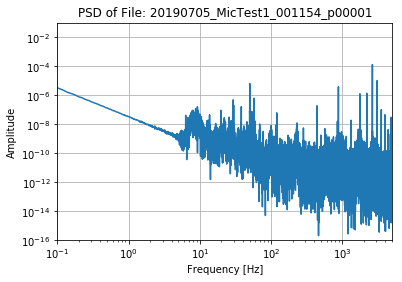

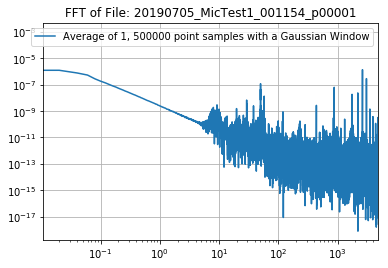

In [34]:
filename = '20190705_MicTest1_001154_p00001'
#plotter(filename)
plt.figure(1)
power_spectral_density(filename, 10000)
plt.figure(1)
get_FFT(filename, sampling_rate=10000, window_size=500000, windows_to_average=1)

In [ ]:
for i in get_files(20190705, sort =True):
    plotter(i)
    power_spectral_density(i)
    get_FFT(i, sampling_rate=10000)
